| | |
|---|---|
| **Name** | Robert Maaskant (s1013777), Jan Thiemen Postema (s1557920) |
| **Group** | 32 |


# Lab 3: Training and testing

In this lab we deal with overfitting and generalisation. We illustrate how these occur by extending last week's lab which was implementing logistic regression using basis functions.

# Logistic regression with base functions

$\newcommand{\x}{\mathbf{x}}\newcommand{\w}{\mathbf{w}}\newcommand{\c}{\mathcal{C}}\newcommand{\feat}{\boldsymbol{\phi}}$

As we have seen last week, the logistic regression models the probability of a class label $\c$ given a datapoint $p(\c|\x)$ as:
$$p(\c|\x) = \sigma(\w^\top\x) = \frac{1}{1+e^{-\w^\top\x}}$$

In this lab, we shall use basis functions to make this model non-linear in $\x$, while still remaining linear in $\w$, by replacing $\x$ with a fixed, non-linear feature vector function $\feat = f(\x)$, so that $p(\c|\x)=\sigma(\w^\top\feat)$

## Data

We start by generating a dataset. As we have seen in the lecture, the central problem of machine learning is to devise algorithms that will generalise to previously unseen data, *i.e.*, that will correctly consider the distribution of the data-generating process into account, rather than merely the distribution of the training data. As you can imagine, this is more difficult for small training sets. The dataset in "data-2class-nonlin" is very similar to the data that we have used before but smaller and, therefore, harder.


In [1]:
# This code is given
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
import copy
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

maxexp=40 # Floats cannot represent exp(maxexp) and larger

def sigma(a):
    '''Logistic function, avoiding warnings of numerical overflows'''
    if a>maxexp:
        return 1.
    if a<-maxexp:
        return 0.
    return 1./(1.+np.exp(-a))
def log1pe(a):
    '''Numerically accurate implementation of log(1+e^x)'''
    if a<-maxexp:
        return 0.
    if a>maxexp:
        return a
    return np.log(1.+np.exp(a))
def logsigma(a):
    '''Numerically accurate log(sigma(x))'''
    return -log1pe(-a)


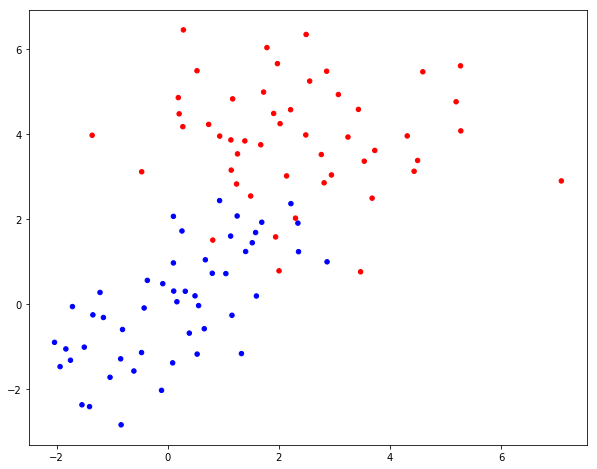

In [2]:
# This code is given 


data = np.load("data-2class-nonlin.npz")
d = data['d']
l = data['l']

colours = [ [ 'b', 'r' ][int(x)] for x in np.nditer(l)] 

plt.scatter(d[:,0],d[:,1],20,colours)
plt.show()




# Basis functions

From the plot, it seems that we can do better than simply use a linear classifier. How about using a polynomial function as a discriminant? What about a quadratic function? Or a third-order polynomial?

Such a polynomial function is a function of the type $y = w_0 + w_1 x + w_2 x^2 + w_3 x^3$, *etc.*. Notice how, in the previous equation, y is a non-linear function of x _but a linear function of $\w$_. Optimising the function with respect to $\w$ is still just as easy as last week. In actual fact, we are interested in a function of $x_1$ and $x_2$ rather than only $x$, but the principle is the same: $f(\x,\w)$ is still a linear function of $\w$. 

The following code allows you to compute the $n$-th order coefficients for a given vector $\x$. That is, for a vector $\x$, say $\x=[x_1,x_2]^\top$, it creates the vector $[1 (=x_1^0), x_1^1, x_2^1, x_1^2, x_1x_2, x_2^2, \dots]$

In [15]:
def feat(v, order):
    res = []
    prevStage = [1.]
    prevcode = [ [ 0 ] * len(v) ]               # list of lists; for every number of prevstage, 
    res = prevStage                             # how often every element of v is part of the product
    for o in range(order):                      # for every order
        stage = []
        code = []
        for ps,pc in zip(prevStage,prevcode):   
            for i in range(len(v)):
                c = [ n for n in pc ]
                c[i] += 1
                if c not in code:
                    stage.append(v[i] * ps)
                    code.append(c)
        res.extend(stage)
        prevStage = stage
        prevcode = code
    return np.array(res)

In [16]:
# This code is given
# Have an array storing the dimensionality of the different models

print feat([2,3],3)
dims = [ len(feat([0,0],o)) for o in range(100)]
print dims 

[  1.   2.   3.   4.   6.   9.   8.  12.  18.  27.]
[1, 3, 6, 10, 15, 21, 28, 36, 45, 55, 66, 78, 91, 105, 120, 136, 153, 171, 190, 210, 231, 253, 276, 300, 325, 351, 378, 406, 435, 465, 496, 528, 561, 595, 630, 666, 703, 741, 780, 820, 861, 903, 946, 990, 1035, 1081, 1128, 1176, 1225, 1275, 1326, 1378, 1431, 1485, 1540, 1596, 1653, 1711, 1770, 1830, 1891, 1953, 2016, 2080, 2145, 2211, 2278, 2346, 2415, 2485, 2556, 2628, 2701, 2775, 2850, 2926, 3003, 3081, 3160, 3240, 3321, 3403, 3486, 3570, 3655, 3741, 3828, 3916, 4005, 4095, 4186, 4278, 4371, 4465, 4560, 4656, 4753, 4851, 4950, 5050]


## Gradient descent and plotting the probability 

Here is some code for visualising the probability of the class given the input and for performing the gradient descent on the weights.

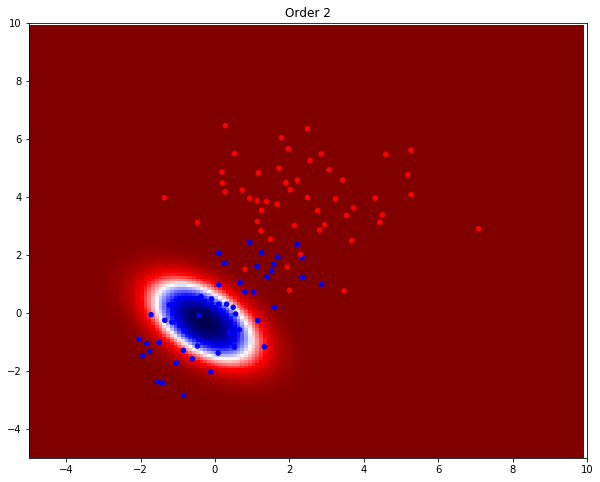

In [34]:
# This code is given

xx,yy = np.mgrid[-5:10:.1,-5:10:.1]

def plotHeat(w):
    order = dims.index(w.size)  # Get the order of polynomial from the size of w
    # This throws an exception if the order of w does not match that of datapoints
    # that were generated by feat(). that is, "dims" must contain the number of elements in w
    p = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            p[i,j] = sigma(w.dot(feat(np.array([xx[i,j], yy[i,j]]), order)))
    plt.pcolor(xx,yy,p,cmap='seismic')
    plt.xlim([-5,10])
    plt.ylim([-5,10])
    plt.title("Order "+str(order))

def plotData():
    plt.scatter(d[:,0],d[:,1],20,colours)
    
w = np.array([0,1,1,1,1,1])
plotHeat(w)
plotData()



In [119]:
# This code is given

def errorfun(w, data, labels):
    '''Numerically accurate implementation of the error function'''
    logprob = 0
    for x,c in zip(data,labels):
        logprob += log1pe(-w.dot(x)) + (1.-c)*w.dot(x)

    return logprob/labels.size

def optimiseDisc(w, data, labels, order, eta=1e-3, maxrun=10000):
    '''Implementation of batch gradient descent with adaptive step size'''
    newError = errorfun(w,data,labels)
    pastError = newError + 10
    es = []
    n=0
    while pastError-newError > 1e-5 and n<maxrun:
        n+=1
        grad = np.zeros(w.shape)
        for x,c in zip(data,labels):
            grad += (sigma(w.dot(x)) - c) * x
        pw = copy.copy(w) 
        w -= eta * grad
        
        pastError = newError
        newError = errorfun(w,data,labels)
        while eta > 0. and pastError - newError < 0: # If the error increases, eta is too large
            eta /= 2                                 # halve it, and
            w = pw - eta * grad                      # try again from the original value of the weights
            newError = errorfun(w,data,labels)
        else:                                        # If the error goes down,
            eta *= 1.2                               # try to increase eta a little, to speed up things.
        
        if newError<pastError:
            es.append(newError)
        else:                                        # If we couldn't decrease the error anymore, 
            break                                    # just give up.
#        print n, pastError, newError, pastError-newError, eta

    return w, newError
    
def optimizeDiscAONE(d, l, order, eta=1e-3, maxrun=10000):
    w = np.repeat(1., dims[1])
    error = 0
    for o in range(1,order+1):
        x = [feat(x, o) for x in d]
        w, error = optimiseDisc(w, x, l, dims[o], 1e-5)
        w = np.append(w, np.repeat(0, dims[o+1] - dims[o]))
    return w[:dims[order]], error
        


In [122]:
order = 3
optimizeDiscAONE(d, l, 3)
#optimiseDisc(w, [feat(x, order) for x in d], l, order, 1e-10)
# Playground for using gradient descent...

(array([-4.70554486,  0.48759861,  1.36083923,  0.25427443, -0.38630437,
         0.13522089,  0.04477851, -0.03236021,  0.00684878,  0.07203037]),
 array([ 0.13488795]))

# Generalisation

Evaluate the error on the training set of gradient descent, with different orders of your feature vector. Pay attention to the evolution of the error function during the training; if you notice that the error goes up at times, your step size $\eta$ is too large and you should reduce it. This error should keep diminishing: if it doesn't, you either stopped training too soon, or (for higher-order functions) you got stuck in a local optimum.

Local optima are a problem for complex models. Sometimes, a complex model really is warranted, but finding optimal parameter values for it is difficult. In general, one solution is to initialise the parameters at random, run multiple optimisation runs, and keep the run with the best results. 

**Question 1 [10 credits]**: In this case, where there is a clear relationship between the parameters of the models of increasing complexity, can you think of a way to ensure that increasing the complexity of the model is guaranteed to reduce the training error (and so that, even if you get stuck in a local optimum, you're at least certain that it is an optimum that's better than the best model you've found so far?) Does this strategy have disadvantages?


*A way to ensure this would be to start with the best found solution in the lower order and initialize the others as zero. Since logistic regression will by definition only choose better solutions, the next solution will be at least as good as the last one. Thus this way you can only improve the solution when increasing the complexity. A disadvantage of this strategy is that if you're stuck in a local optimum from the start, you might stay stuck in that same local optimum, no matter how much you increase the complexity of the model.*


**Question 2 [10 credits]**: Divide your data into a training and test set. Plot the evolution of the error on both the train and the test set in function of the order of the polynomial.


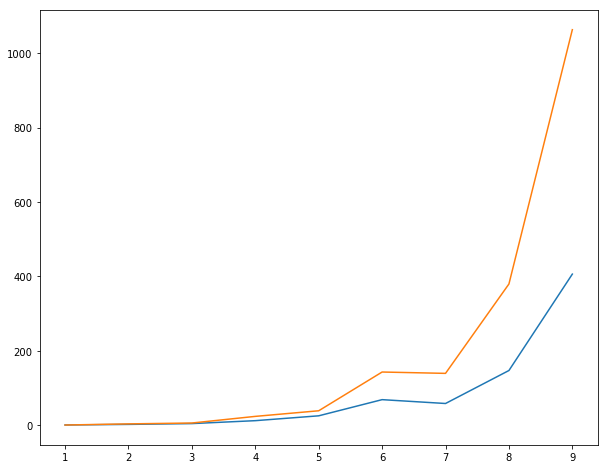

In [126]:
# Your answer to Q2 comes here
divider = len(d)/4*3
d_train = d[0:divider]
d_test = d[divider:]
l_train = l[0:divider]
l_test = l[divider:]

error_train = []
error_test = []

for order in range(1,10):
    w = np.repeat(1., dims[order])

    w, error = optimiseDisc(w, [feat(x, order) for x in d_train], l_train, order, 1e-10)
    error_train.append(error)
    error_test.append(errorfun(w, [feat(x, order) for x in d_test], l_test))
plt.plot(range(1,10), error_train)
plt.plot(range(1,10), error_test)

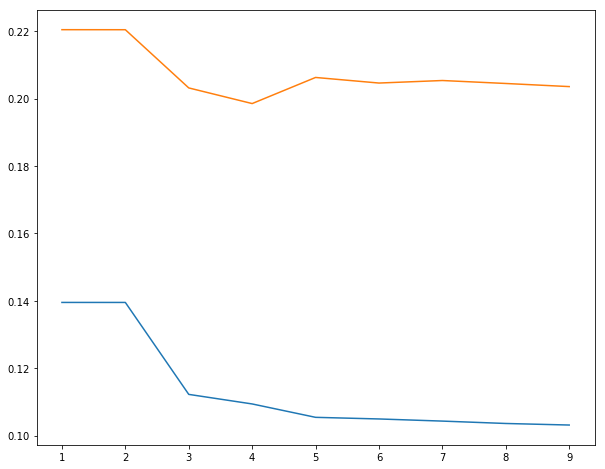

In [127]:
# Your answer to Q2 comes here
#Version that uses the implementation of Q1
error_train = []
error_test = []

for order in range(1,10):
    w = np.repeat(1., dims[order])
    w, error = optimizeDiscAONE(d_train, l_train, order)

    error_train.append(error)
    error_test.append(errorfun(w, [feat(x, order) for x in d_test], l_test))
plt.plot(range(1,10), error_train)
plt.plot(range(1,10), error_test)


**Question 3 [10 credits]**: Now perform 5-fold cross-validation on the data set and create the same plot as in the previous question. Doing cross-validation gives you a more accurate and stable estimate of the error of your model on unseen data, but it also gives you an idea of the spread of this error and therefore a (optimistic) idea of the upper and lower bounds on your error. Use error bars to show the standard deviation on your cross-validation error.



In [151]:
# Your answer to Q3 comes here
k = 5
order = 10

d_folds = np.split(d, k)
l_folds = np.split(l, k)

error_train = [0] * order
error_test = [0] * order
    
for o in range(1, order+1):
    error_train[o-1] = []
    error_test[o-1] = []
    
    for fold in range(k):
        d_train = np.array([x for i, f in enumerate(d_folds) if i <> fold for x in f])
        d_test = d_folds[fold]
        l_train = np.array([x for i, f in enumerate(l_folds) if i <> fold for x in f])
        l_test = l_folds[fold]

        w = np.repeat(1., dims[o])
        w, error = optimizeDiscAONE(d_train, l_train, o, 1e-10)
        
        error_train[o-1].append(error)
        error_test[o-1].append(errorfun(w, [feat(x, o) for x in d_test], l_test))
        

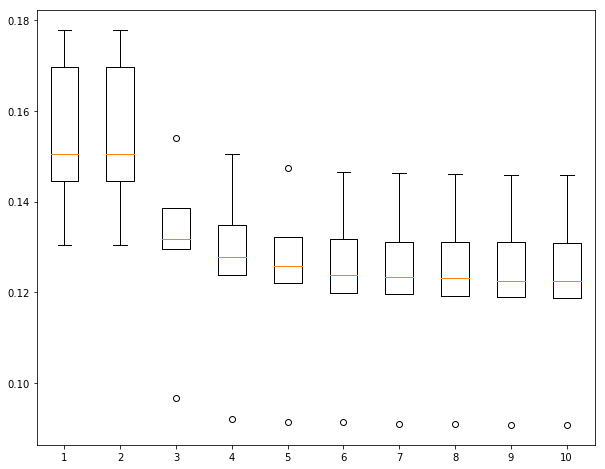

In [152]:
plt.boxplot(error_train)
plt.show()

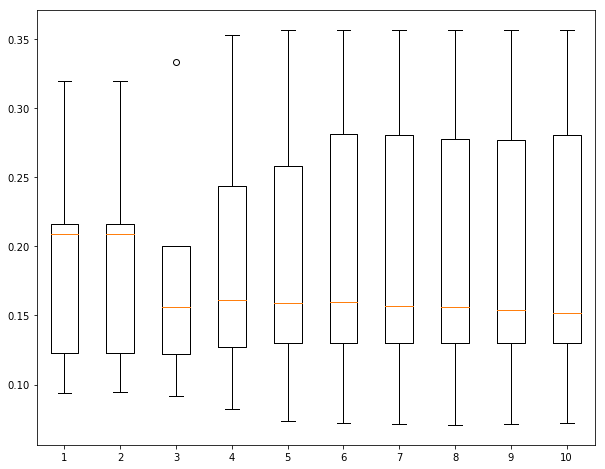

In [153]:
plt.boxplot(error_test)
plt.show()

**Question 4 [5 credits]**: What order should the polynomial be, do you think? Why do you think that?

*The order of the polynomial should be 3. We believe this is the correct value, because if we increase the order beyond that, the test error increases. Both the variance within and the median. If the order is increased dramatically, the variance also increase dramatically indicating overfitting on the training data.*